<a href="https://colab.research.google.com/github/shavirazh/text-classification-using-CNN-with-Word2vec-Glove-FastText/blob/main/text-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import gensim
from wordcloud import WordCloud, STOPWORDS
from gensim.models import KeyedVectors
import gensim.models.keyedvectors as word2vec
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Activation, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape, Flatten, Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from keras.models import model_from_json
import pickle
import json
import logging

logging.basicConfig(format='%(asctime)s : %(levelname) s : %(message)s', level=logging.INFO)

print('ALL LIBRARY IMPORTED.')

from google.colab import drive
drive.mount('/content/drive')

ALL LIBRARY IMPORTED.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load & Preprocess Data

In [ ]:
df = pd.read_csv('drive/MyDrive/dataset/tweets_data.csv')
print('Data loaded.\n')

Data loaded.



In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.dropna(inplace=True)

## Take random 10.000 data from each labels, total 20.000 data

In [ ]:
df_1 = df[df['label'] == 1]
df_0 = df[df['label'] == 0]

df_1 = df_1.sample(n=10000)
df_0 = df_0.sample(n=10000)

In [ ]:
df = pd.concat([df_1, df_0], ignore_index = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   20000 non-null  int64 
 1   tweet   20000 non-null  object
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [ ]:
df['label'].value_counts()

1    10000
0    10000
Name: label, dtype: int64

# Build Corpus

In [ ]:
# Frequent words removal
freq = ['rt','im','ð','ðð','ððð','ðððð','ððððð','amp','u','â','retweet']
df['tweet_punc_remv'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df.drop('tweet', axis=1, inplace=True)
df = df.rename(columns={'tweet_punc_remv':'tweet'})

# Membuat korpus
corpus = df['tweet'].apply(gensim.utils.simple_preprocess)

# Memberi indeks pada teks
token = Tokenizer()
token.fit_on_texts(corpus)
token.index_word
token.texts_to_sequences(corpus)

#Jumlah kata dalam korpus
vocal = len(token.index_word)+1
print('There are {} words.'.format(vocal))

There are 24474 words.


# Defining X and Y & Pad sequences

In [ ]:
maxword = 30
X = token.texts_to_sequences(corpus)
X = pad_sequences(X, maxlen = maxword, padding='post')
y = df['label'].values.tolist()
print('X and y defined')

X and y defined


# Splitting data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state = 42)
print('Training and testing data defined.')

Training and testing data defined.


In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
print('Done')

Done


# Word2vec

## Embedding layer

In [ ]:
pretrainedpath = 'drive/MyDrive/dataset/w2vModel.bin'
w2vmodel = KeyedVectors.load_word2vec_format(pretrainedpath, binary=True)
print('Model word2vec loaded.')

2022-07-20 11:41:16,055 : INFO : loading projection weights from drive/MyDrive/dataset/w2vModel.bin
2022-07-20 11:41:18,710 : INFO : loaded (150000, 300) matrix from drive/MyDrive/dataset/w2vModel.bin


Model word2vec loaded.


In [ ]:
embedding_layer = Embedding(input_dim=150000, output_dim=300, weights=[w2vmodel.vectors], 
                            input_length=X.shape[1])
print('Embedding layer defined.')

Embedding layer defined.


## CNN Model

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01),
                  kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01),
                  kernel_initializer='he_normal'))
model.add(MaxPooling1D(pool_size=3))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(32, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 300)           45000000  
                                                                 
 batch_normalization (BatchN  (None, 30, 300)          1200      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 30, 300)           0         
                                                                 
 conv1d (Conv1D)             (None, 30, 128)           192128    
                                                                 
 batch_normalization_1 (Batc  (None, 30, 128)          512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Total params: 45,333,233
Trainable params: 45,329,369
Non-trainable params: 3,864
_________________________________________________________________


## Hyperparameter tuning 

In [ ]:
w2vHistory_2032_3 = model.fit(X_train, y_train, 
                          epochs=20, 
                          validation_split=0.2, 
                          batch_size=32,
                          validation_data=(X_test, y_test))

Epoch 1/20
375/375 [==============================] - 96s 252ms/step - loss: 3.3490 - accuracy: 0.8828 - val_loss: 1.5086 - val_accuracy: 0.9190
Epoch 2/20
375/375 [==============================] - 91s 243ms/step - loss: 0.6938 - accuracy: 0.9788 - val_loss: 0.5764 - val_accuracy: 0.9310
Epoch 3/20
375/375 [==============================] - 90s 240ms/step - loss: 0.2883 - accuracy: 0.9814 - val_loss: 0.5129 - val_accuracy: 0.9317
Epoch 4/20
375/375 [==============================] - 92s 244ms/step - loss: 0.2706 - accuracy: 0.9834 - val_loss: 0.5588 - val_accuracy: 0.9337
Epoch 5/20
375/375 [==============================] - 91s 243ms/step - loss: 0.2916 - accuracy: 0.9824 - val_loss: 0.5412 - val_accuracy: 0.9300
Epoch 6/20
375/375 [==============================] - 90s 240ms/step - loss: 0.2659 - accuracy: 0.9821 - val_loss: 0.4543 - val_accuracy: 0.9343
Epoch 7/20
375/375 [==============================] - 89s 237ms/step - loss: 0.2476 - accuracy: 0.9837 - val_loss: 0.5136 - val_ac

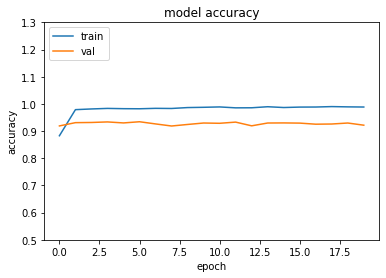

In [ ]:
plt.plot(w2vHistory_2032_3.history['accuracy'])
plt.plot(w2vHistory_2032_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.yticks((0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3))
plt.legend(['train', 'val'], loc='upper left')
plt.show()

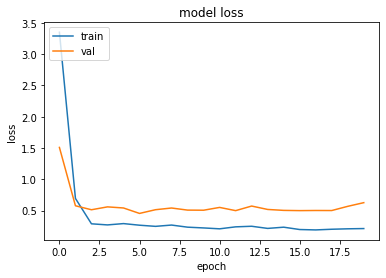

In [ ]:
plt.plot(w2vHistory_2032_3.history['loss'])
plt.plot(w2vHistory_2032_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model.evaluate(X_test, y_test, batch_size=32)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

157/157 [==============================] - 1s 9ms/step - loss: 0.6013 - accuracy: 0.9270
Model loss: 0.6013344526290894
Model acc: 0.9269999861717224


### Epochs 20, batch size 32

In [ ]:
w2vHistory_2032 = model.fit(X_train, y_train, 
                          epochs=20, 
                          validation_split=0.2, 
                          batch_size=32,
                          validation_data=(X_test, y_test))

Epoch 1/20
375/375 [==============================] - 110s 290ms/step - loss: 4.2562 - accuracy: 0.6272 - val_loss: 4.2849 - val_accuracy: 0.4923
Epoch 2/20
375/375 [==============================] - 88s 234ms/step - loss: 1.7681 - accuracy: 0.8404 - val_loss: 1.6870 - val_accuracy: 0.6487
Epoch 3/20
375/375 [==============================] - 87s 232ms/step - loss: 0.8194 - accuracy: 0.9087 - val_loss: 0.8546 - val_accuracy: 0.8177
Epoch 4/20
375/375 [==============================] - 88s 234ms/step - loss: 0.5358 - accuracy: 0.9373 - val_loss: 0.5923 - val_accuracy: 0.9030
Epoch 5/20
375/375 [==============================] - 87s 232ms/step - loss: 0.4536 - accuracy: 0.9538 - val_loss: 0.5351 - val_accuracy: 0.9230
Epoch 6/20
375/375 [==============================] - 88s 234ms/step - loss: 0.4070 - accuracy: 0.9604 - val_loss: 0.5289 - val_accuracy: 0.9190
Epoch 7/20
375/375 [==============================] - 90s 239ms/step - loss: 0.3887 - accuracy: 0.9641 - val_loss: 0.5316 - val_a

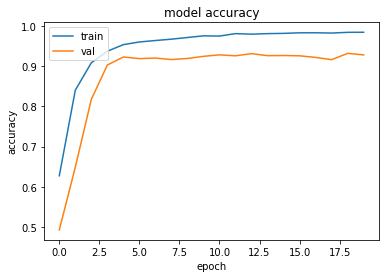

In [ ]:
plt.plot(w2vHistory_2032.history['accuracy'])
plt.plot(w2vHistory_2032.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

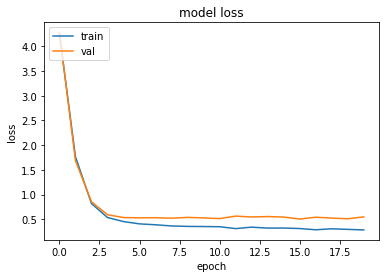

In [ ]:
plt.plot(w2vHistory_2032.history['loss'])
plt.plot(w2vHistory_2032.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model.evaluate(X_test, y_test, batch_size=32)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

157/157 [==============================] - 2s 12ms/step - loss: 0.5649 - accuracy: 0.9274
Model loss: 0.564949095249176
Model acc: 0.9273999929428101


### Epochs 20, batch size 64

In [ ]:
w2vHistory_2064 = model.fit(X_train, y_train, 
                          epochs=20, 
                          validation_split=0.2, 
                          batch_size=64,
                          validation_data=(X_test, y_test))

Epoch 1/20
188/188 [==============================] - 59s 302ms/step - loss: 4.7054 - accuracy: 0.5751 - val_loss: 3.8744 - val_accuracy: 0.4923
Epoch 2/20
188/188 [==============================] - 53s 283ms/step - loss: 2.5201 - accuracy: 0.7441 - val_loss: 3.8050 - val_accuracy: 0.4923
Epoch 3/20
188/188 [==============================] - 54s 285ms/step - loss: 1.2594 - accuracy: 0.8801 - val_loss: 1.9141 - val_accuracy: 0.5523
Epoch 4/20
188/188 [==============================] - 53s 283ms/step - loss: 0.6814 - accuracy: 0.9308 - val_loss: 0.9134 - val_accuracy: 0.7687
Epoch 5/20
188/188 [==============================] - 53s 282ms/step - loss: 0.4892 - accuracy: 0.9466 - val_loss: 0.6934 - val_accuracy: 0.8533
Epoch 6/20
188/188 [==============================] - 53s 281ms/step - loss: 0.4082 - accuracy: 0.9564 - val_loss: 0.5586 - val_accuracy: 0.9003
Epoch 7/20
188/188 [==============================] - 53s 280ms/step - loss: 0.3467 - accuracy: 0.9695 - val_loss: 0.5124 - val_ac

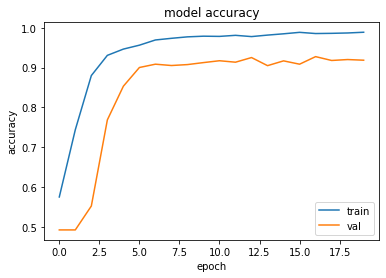

In [ ]:
plt.plot(w2vHistory_2064.history['accuracy'])
plt.plot(w2vHistory_2064.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.yticks((0.5,0.6,0.7,0.8,0.9,1.0))
plt.legend(['train', 'val'], loc='lower right')
plt.show()

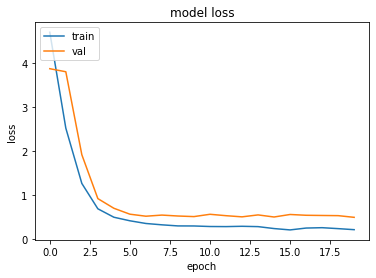

In [ ]:
plt.plot(w2vHistory_2064.history['loss'])
plt.plot(w2vHistory_2064.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model.evaluate(X_test, y_test, batch_size=64)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

79/79 [==============================] - 1s 18ms/step - loss: 0.4408 - accuracy: 0.9296
Model loss: 0.44075870513916016
Model acc: 0.9296000003814697


### Epochs 20, batch size 128

In [ ]:
w2vHistory_20128 = model.fit(X_train, y_train, 
                          epochs=20, 
                          validation_split=0.2, 
                          batch_size=64,
                          validation_data=(X_test, y_test))

Epoch 1/20
188/188 [==============================] - 57s 293ms/step - loss: 4.5579 - accuracy: 0.5957 - val_loss: 3.9841 - val_accuracy: 0.4923
Epoch 2/20
188/188 [==============================] - 55s 293ms/step - loss: 2.3084 - accuracy: 0.7808 - val_loss: 3.5187 - val_accuracy: 0.4927
Epoch 3/20
188/188 [==============================] - 55s 294ms/step - loss: 1.1264 - accuracy: 0.8867 - val_loss: 1.4891 - val_accuracy: 0.6143
Epoch 4/20
188/188 [==============================] - 56s 296ms/step - loss: 0.6080 - accuracy: 0.9365 - val_loss: 0.8213 - val_accuracy: 0.8030
Epoch 5/20
188/188 [==============================] - 55s 294ms/step - loss: 0.4425 - accuracy: 0.9532 - val_loss: 0.5402 - val_accuracy: 0.8980
Epoch 6/20
188/188 [==============================] - 54s 290ms/step - loss: 0.3675 - accuracy: 0.9640 - val_loss: 0.5063 - val_accuracy: 0.9127
Epoch 7/20
188/188 [==============================] - 55s 291ms/step - loss: 0.3402 - accuracy: 0.9665 - val_loss: 0.5062 - val_ac

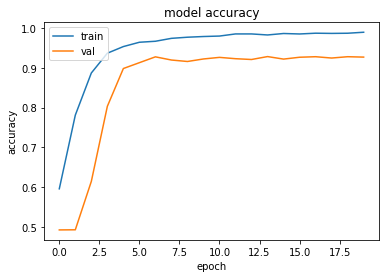

In [ ]:
plt.plot(w2vHistory_20128.history['accuracy'])
plt.plot(w2vHistory_20128.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

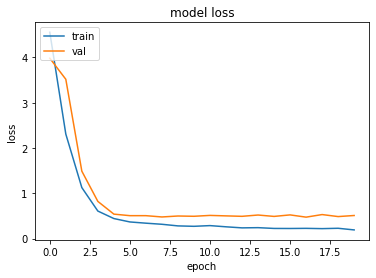

In [ ]:
plt.plot(w2vHistory_20128.history['loss'])
plt.plot(w2vHistory_20128.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model.evaluate(X_test, y_test, batch_size=128)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

40/40 [==============================] - 2s 51ms/step - loss: 0.5080 - accuracy: 0.9266
Model loss: 0.50798499584198
Model acc: 0.9265999794006348


### Epochs 30, batch size 32

In [ ]:
w2vHistory_3032 = model.fit(X_train, y_train, 
                          epochs=30, 
                          validation_split=0.2, 
                          batch_size=32,
                          validation_data=(X_test, y_test))

Epoch 1/30
375/375 [==============================] - 190s 499ms/step - loss: 4.1198 - accuracy: 0.6197 - val_loss: 3.7382 - val_accuracy: 0.4923
Epoch 2/30
375/375 [==============================] - 188s 502ms/step - loss: 1.6044 - accuracy: 0.8365 - val_loss: 1.3147 - val_accuracy: 0.6983
Epoch 3/30
375/375 [==============================] - 188s 501ms/step - loss: 0.7376 - accuracy: 0.9128 - val_loss: 0.6832 - val_accuracy: 0.8877
Epoch 4/30
375/375 [==============================] - 187s 500ms/step - loss: 0.5501 - accuracy: 0.9377 - val_loss: 0.6088 - val_accuracy: 0.9033
Epoch 5/30
375/375 [==============================] - 191s 509ms/step - loss: 0.4696 - accuracy: 0.9512 - val_loss: 0.5941 - val_accuracy: 0.8977
Epoch 6/30
375/375 [==============================] - 189s 503ms/step - loss: 0.4331 - accuracy: 0.9578 - val_loss: 0.5576 - val_accuracy: 0.9327
Epoch 7/30
375/375 [==============================] - 191s 509ms/step - loss: 0.3959 - accuracy: 0.9649 - val_loss: 0.5191 -

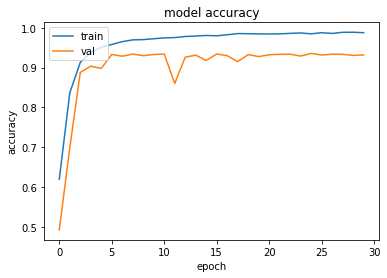

In [ ]:
plt.plot(w2vHistory_3032.history['accuracy'])
plt.plot(w2vHistory_3032.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

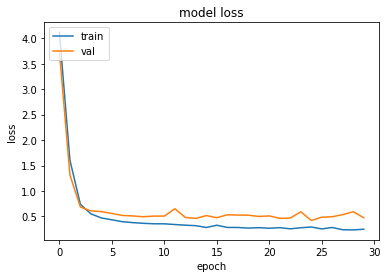

In [ ]:
plt.plot(w2vHistory_3032.history['loss'])
plt.plot(w2vHistory_3032.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model.evaluate(X_test, y_test, batch_size=32)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

157/157 [==============================] - 2s 14ms/step - loss: 0.5010 - accuracy: 0.9242
Model loss: 0.501036524772644
Model acc: 0.9241999983787537


### Epochs 30, batch size 64

In [ ]:
w2vHistory_3064 = model.fit(X_train, y_train, 
                          epochs=30, 
                          validation_split=0.2, 
                          batch_size=64,
                          validation_data=(X_test, y_test))

Epoch 1/30
188/188 [==============================] - 109s 563ms/step - loss: 4.6048 - accuracy: 0.5788 - val_loss: 3.9433 - val_accuracy: 0.4923
Epoch 2/30
188/188 [==============================] - 105s 559ms/step - loss: 2.3173 - accuracy: 0.7684 - val_loss: 3.8940 - val_accuracy: 0.4923
Epoch 3/30
188/188 [==============================] - 106s 562ms/step - loss: 1.1100 - accuracy: 0.8878 - val_loss: 1.7687 - val_accuracy: 0.5550
Epoch 4/30
188/188 [==============================] - 106s 562ms/step - loss: 0.6322 - accuracy: 0.9297 - val_loss: 0.7417 - val_accuracy: 0.8427
Epoch 5/30
188/188 [==============================] - 107s 570ms/step - loss: 0.4624 - accuracy: 0.9502 - val_loss: 0.5589 - val_accuracy: 0.8877
Epoch 6/30
188/188 [==============================] - 106s 564ms/step - loss: 0.3936 - accuracy: 0.9589 - val_loss: 0.4995 - val_accuracy: 0.9117
Epoch 7/30
188/188 [==============================] - 106s 562ms/step - loss: 0.3548 - accuracy: 0.9668 - val_loss: 0.5058 -

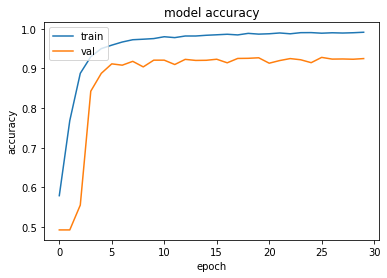

In [ ]:
plt.plot(w2vHistory_3064.history['accuracy'])
plt.plot(w2vHistory_3064.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

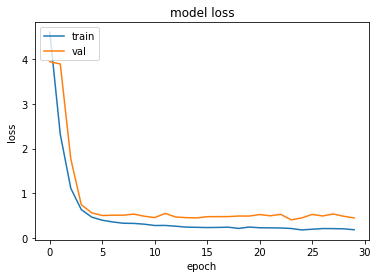

In [ ]:
plt.plot(w2vHistory_3064.history['loss'])
plt.plot(w2vHistory_3064.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model.evaluate(X_test, y_test, batch_size=64)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

79/79 [==============================] - 2s 23ms/step - loss: 0.4929 - accuracy: 0.9198
Model loss: 0.4928644597530365
Model acc: 0.9197999835014343


### Epochs 30, batch size 128

In [ ]:
w2vHistory_30128 = model.fit(X_train, y_train, 
                          epochs=30, 
                          validation_split=0.2, 
                          batch_size=128,
                          validation_data=(X_test, y_test))

Epoch 1/30
94/94 [==============================] - 67s 671ms/step - loss: 5.0194 - accuracy: 0.5608 - val_loss: 4.4438 - val_accuracy: 0.4923
Epoch 2/30
94/94 [==============================] - 64s 685ms/step - loss: 3.1737 - accuracy: 0.6815 - val_loss: 4.6254 - val_accuracy: 0.4923
Epoch 3/30
94/94 [==============================] - 63s 675ms/step - loss: 1.8609 - accuracy: 0.8324 - val_loss: 4.4684 - val_accuracy: 0.4923
Epoch 4/30
94/94 [==============================] - 63s 670ms/step - loss: 1.0868 - accuracy: 0.9027 - val_loss: 3.5905 - val_accuracy: 0.4923
Epoch 5/30
94/94 [==============================] - 62s 659ms/step - loss: 0.6770 - accuracy: 0.9352 - val_loss: 2.6759 - val_accuracy: 0.4927
Epoch 6/30
94/94 [==============================] - 62s 659ms/step - loss: 0.4711 - accuracy: 0.9517 - val_loss: 1.6553 - val_accuracy: 0.5637
Epoch 7/30
94/94 [==============================] - 62s 658ms/step - loss: 0.3776 - accuracy: 0.9620 - val_loss: 0.8203 - val_accuracy: 0.7967

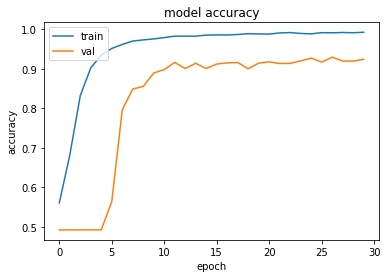

In [ ]:
plt.plot(w2vHistory_30128.history['accuracy'])
plt.plot(w2vHistory_30128.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

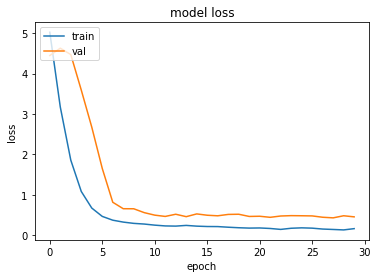

In [ ]:
plt.plot(w2vHistory_30128.history['loss'])
plt.plot(w2vHistory_30128.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model.evaluate(X_test, y_test, batch_size=128)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

40/40 [==============================] - 2s 41ms/step - loss: 0.4622 - accuracy: 0.9244
Model loss: 0.4622427225112915
Model acc: 0.9243999719619751


### Fixed model (epochs 20 batch size 64)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01),
                  kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01),
                  kernel_initializer='he_normal'))
model.add(MaxPooling1D(pool_size=3))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(32, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 300)           45000000  
                                                                 
 batch_normalization_6 (Batc  (None, 30, 300)          1200      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 30, 300)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 30, 128)           192128    
                                                                 
 batch_normalization_7 (Batc  (None, 30, 128)          512       
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 30, 128)          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
cnnModelW2v = model.fit(X_train, y_train,
                        epochs=20,
                        batch_size=64,
                        validation_data=(X_test, y_test))

Epoch 1/20
235/235 [==============================] - 140s 581ms/step - loss: 3.6019 - accuracy: 0.8619 - val_loss: 1.8684 - val_accuracy: 0.8634
Epoch 2/20
235/235 [==============================] - 134s 570ms/step - loss: 0.8868 - accuracy: 0.9713 - val_loss: 0.5784 - val_accuracy: 0.9342
Epoch 3/20
235/235 [==============================] - 132s 563ms/step - loss: 0.3566 - accuracy: 0.9784 - val_loss: 0.4339 - val_accuracy: 0.9374
Epoch 4/20
235/235 [==============================] - 132s 564ms/step - loss: 0.2644 - accuracy: 0.9793 - val_loss: 0.4428 - val_accuracy: 0.9326
Epoch 5/20
235/235 [==============================] - 133s 565ms/step - loss: 0.2511 - accuracy: 0.9833 - val_loss: 0.4861 - val_accuracy: 0.9332
Epoch 6/20
235/235 [==============================] - 133s 565ms/step - loss: 0.2514 - accuracy: 0.9825 - val_loss: 0.4280 - val_accuracy: 0.9330
Epoch 7/20
235/235 [==============================] - 136s 579ms/step - loss: 0.2011 - accuracy: 0.9872 - val_loss: 0.4641 -

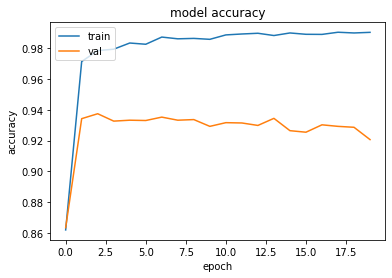

In [ ]:
plt.plot(cnnModelW2v.history['accuracy'])
plt.plot(cnnModelW2v.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

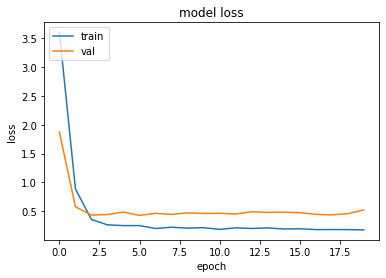

In [ ]:
plt.plot(cnnModelW2v.history['loss'])
plt.plot(cnnModelW2v.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model.evaluate(X_test, y_test, batch_size=64)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

79/79 [==============================] - 2s 27ms/step - loss: 0.5233 - accuracy: 0.9206
Model loss: 0.5233425498008728
Model acc: 0.9205999970436096


# Glove

## Embedding layer

In [ ]:
import os

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-07-22 05:31:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-07-22 05:31:22--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-22 05:31:22--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip -q glove.6B.zip

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.300d.txt'
word2vec_output_file = 'word2vec.txt'
# The first step is to convert the GloVe file format to the word2vec file format. 
# The only difference is the addition of a small header line. This can be done by calling the 
# glove2word2vec() function.
glove2word2vec(glove_input_file, word2vec_output_file)

2022-07-22 07:11:02,075 : INFO : converting 400000 vectors from glove.6B.300d.txt to word2vec.txt


(400000, 300)

In [ ]:
from gensim.models import KeyedVectors
glove = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False, limit=150000)

2022-07-22 07:11:36,023 : INFO : loading projection weights from word2vec.txt
2022-07-22 07:12:01,288 : INFO : loaded (150000, 300) matrix from word2vec.txt


In [ ]:
embedding_layer = Embedding(input_dim=150000, output_dim=300, weights=[glove.vectors], 
                            input_length=X.shape[1])
print('Embedding layer defined.')

Embedding layer defined.


## CNN Model

In [ ]:
model2 = Sequential()
model2.add(embedding_layer)
model2.add(BatchNormalization())
model2.add(Dropout(0.4))
model2.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01),
                  kernel_initializer='he_normal'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))
model2.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01),
                  kernel_initializer='he_normal'))
model2.add(MaxPooling1D(pool_size=3))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))
model2.add(Flatten())
model2.add(BatchNormalization())
model2.add(Dropout(0.4))
model2.add(Dense(64, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))
model2.add(Dense(32, activation = 'relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))
model2.add(Dense(1, activation='sigmoid'))

adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 300)           45000000  
                                                                 
 batch_normalization (BatchN  (None, 30, 300)          1200      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 30, 300)           0         
                                                                 
 conv1d (Conv1D)             (None, 30, 128)           192128    
                                                                 
 batch_normalization_1 (Batc  (None, 30, 128)          512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Hyperparameter tuning 

### Epochs 20, batch size 32

In [ ]:
glvHistory_2032 = model2.fit(X_train, y_train, 
                          epochs=20, 
                          validation_split=0.2, 
                          batch_size=32,
                          validation_data=(X_test, y_test))

Epoch 1/20
375/375 [==============================] - 183s 482ms/step - loss: 4.2300 - accuracy: 0.6118 - val_loss: 3.2172 - val_accuracy: 0.4930
Epoch 2/20
375/375 [==============================] - 181s 482ms/step - loss: 1.6890 - accuracy: 0.8179 - val_loss: 1.0487 - val_accuracy: 0.8570
Epoch 3/20
375/375 [==============================] - 178s 475ms/step - loss: 0.7825 - accuracy: 0.8907 - val_loss: 0.6052 - val_accuracy: 0.9120
Epoch 4/20
375/375 [==============================] - 179s 477ms/step - loss: 0.5137 - accuracy: 0.9155 - val_loss: 0.4578 - val_accuracy: 0.9247
Epoch 5/20
375/375 [==============================] - 183s 488ms/step - loss: 0.4152 - accuracy: 0.9380 - val_loss: 0.4776 - val_accuracy: 0.9247
Epoch 6/20
375/375 [==============================] - 179s 477ms/step - loss: 0.4013 - accuracy: 0.9456 - val_loss: 0.4770 - val_accuracy: 0.9280
Epoch 7/20
375/375 [==============================] - 179s 477ms/step - loss: 0.3785 - accuracy: 0.9542 - val_loss: 0.4467 -

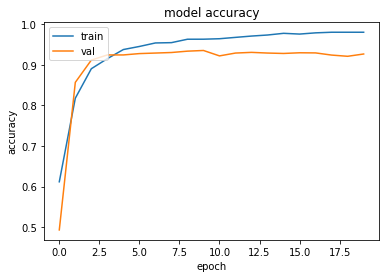

In [ ]:
plt.plot(glvHistory_2032.history['accuracy'])
plt.plot(glvHistory_2032.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

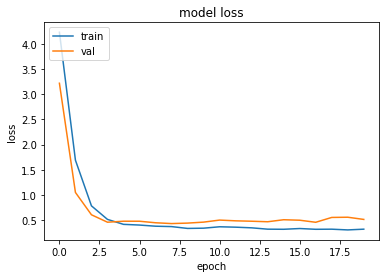

In [ ]:
plt.plot(glvHistory_2032.history['loss'])
plt.plot(glvHistory_2032.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model2.evaluate(X_test, y_test, batch_size=32)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

157/157 [==============================] - 2s 13ms/step - loss: 0.5016 - accuracy: 0.9298
Model loss: 0.5016443133354187
Model acc: 0.9297999739646912


### Epochs 20, batch size 64

In [ ]:
glvHistory_2064 = model2.fit(X_train, y_train, 
                          epochs=20, 
                          validation_split=0.2, 
                          batch_size=64,
                          validation_data=(X_test, y_test))

Epoch 1/20
188/188 [==============================] - 117s 584ms/step - loss: 4.7694 - accuracy: 0.5499 - val_loss: 4.0044 - val_accuracy: 0.4923
Epoch 2/20
188/188 [==============================] - 103s 547ms/step - loss: 2.5886 - accuracy: 0.7190 - val_loss: 3.0974 - val_accuracy: 0.4987
Epoch 3/20
188/188 [==============================] - 102s 544ms/step - loss: 1.3752 - accuracy: 0.8377 - val_loss: 1.3725 - val_accuracy: 0.6947
Epoch 4/20
188/188 [==============================] - 101s 536ms/step - loss: 0.7868 - accuracy: 0.8939 - val_loss: 0.7038 - val_accuracy: 0.8663
Epoch 5/20
188/188 [==============================] - 105s 558ms/step - loss: 0.5312 - accuracy: 0.9197 - val_loss: 0.5850 - val_accuracy: 0.8667
Epoch 6/20
188/188 [==============================] - 102s 542ms/step - loss: 0.4209 - accuracy: 0.9371 - val_loss: 0.4822 - val_accuracy: 0.8993
Epoch 7/20
188/188 [==============================] - 102s 545ms/step - loss: 0.3547 - accuracy: 0.9467 - val_loss: 0.4503 -

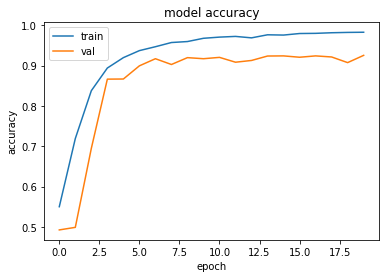

In [ ]:
plt.plot(glvHistory_2064.history['accuracy'])
plt.plot(glvHistory_2064.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

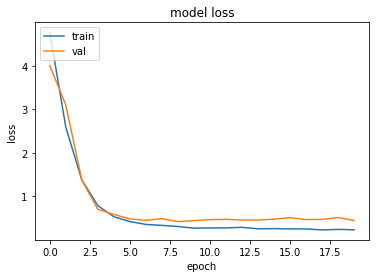

In [ ]:
plt.plot(glvHistory_2064.history['loss'])
plt.plot(glvHistory_2064.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model2.evaluate(X_test, y_test, batch_size=64)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

79/79 [==============================] - 2s 21ms/step - loss: 0.4579 - accuracy: 0.9224
Model loss: 0.45791566371917725
Model acc: 0.9223999977111816


### Epochs 20, batch size 128

In [ ]:
glvHistory_20128 = model2.fit(X_train, y_train, 
                          epochs=20, 
                          validation_split=0.2, 
                          batch_size=128,
                          validation_data=(X_test, y_test))

Epoch 1/20
94/94 [==============================] - 66s 651ms/step - loss: 5.0472 - accuracy: 0.5515 - val_loss: 4.2623 - val_accuracy: 0.4923
Epoch 2/20
94/94 [==============================] - 60s 635ms/step - loss: 3.2968 - accuracy: 0.6633 - val_loss: 3.8889 - val_accuracy: 0.4923
Epoch 3/20
94/94 [==============================] - 59s 631ms/step - loss: 2.0605 - accuracy: 0.7928 - val_loss: 3.4248 - val_accuracy: 0.4923
Epoch 4/20
94/94 [==============================] - 59s 631ms/step - loss: 1.2719 - accuracy: 0.8708 - val_loss: 2.3061 - val_accuracy: 0.4950
Epoch 5/20
94/94 [==============================] - 61s 645ms/step - loss: 0.8178 - accuracy: 0.9067 - val_loss: 1.4193 - val_accuracy: 0.6007
Epoch 6/20
94/94 [==============================] - 59s 632ms/step - loss: 0.5745 - accuracy: 0.9282 - val_loss: 1.0082 - val_accuracy: 0.6900
Epoch 7/20
94/94 [==============================] - 60s 634ms/step - loss: 0.4468 - accuracy: 0.9384 - val_loss: 0.6018 - val_accuracy: 0.8540

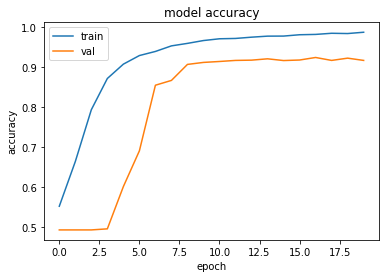

In [ ]:
plt.plot(glvHistory_20128.history['accuracy'])
plt.plot(glvHistory_20128.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

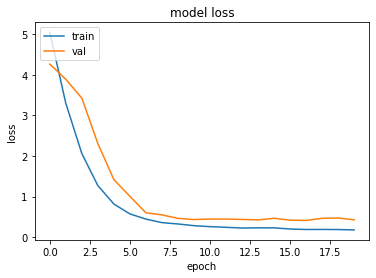

In [ ]:
plt.plot(glvHistory_20128.history['loss'])
plt.plot(glvHistory_20128.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model2.evaluate(X_test, y_test, batch_size=128)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

40/40 [==============================] - 2s 38ms/step - loss: 0.4130 - accuracy: 0.9200
Model loss: 0.4129597544670105
Model acc: 0.9200000166893005


### Epochs 30, batch size 32

In [ ]:
glvHistory_3032 = model2.fit(X_train, y_train, 
                          epochs=30, 
                          validation_split=0.2, 
                          batch_size=32,
                          validation_data=(X_test, y_test))

Epoch 1/30
375/375 [==============================] - 188s 494ms/step - loss: 4.3379 - accuracy: 0.5784 - val_loss: 3.2196 - val_accuracy: 0.4927
Epoch 2/30
375/375 [==============================] - 186s 496ms/step - loss: 1.8494 - accuracy: 0.7838 - val_loss: 1.3223 - val_accuracy: 0.7267
Epoch 3/30
375/375 [==============================] - 184s 492ms/step - loss: 0.8559 - accuracy: 0.8771 - val_loss: 0.6424 - val_accuracy: 0.9077
Epoch 4/30
375/375 [==============================] - 182s 485ms/step - loss: 0.5504 - accuracy: 0.9138 - val_loss: 0.4739 - val_accuracy: 0.9177
Epoch 5/30
375/375 [==============================] - 182s 486ms/step - loss: 0.4297 - accuracy: 0.9296 - val_loss: 0.4364 - val_accuracy: 0.9303
Epoch 6/30
375/375 [==============================] - 188s 502ms/step - loss: 0.3982 - accuracy: 0.9433 - val_loss: 0.4835 - val_accuracy: 0.9203
Epoch 7/30
375/375 [==============================] - 182s 485ms/step - loss: 0.3658 - accuracy: 0.9514 - val_loss: 0.4730 -

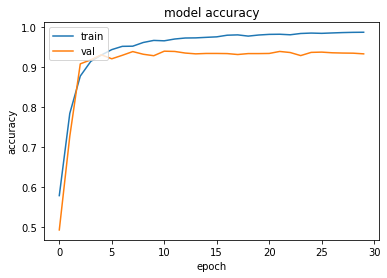

In [ ]:
plt.plot(glvHistory_3032.history['accuracy'])
plt.plot(glvHistory_3032.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

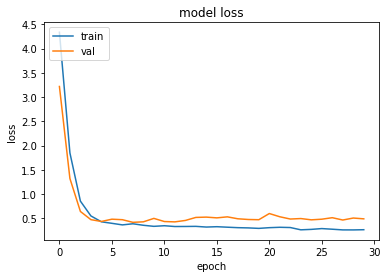

In [ ]:
plt.plot(glvHistory_3032.history['loss'])
plt.plot(glvHistory_3032.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model2.evaluate(X_test, y_test, batch_size=32)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

157/157 [==============================] - 3s 22ms/step - loss: 0.5213 - accuracy: 0.9258
Model loss: 0.5213233232498169
Model acc: 0.9258000254631042


### Epochs 30, batch size 64

In [ ]:
aaaa

In [ ]:
glvHistory_3064 = model2.fit(X_train, y_train, 
                          epochs=30, 
                          validation_split=0.2, 
                          batch_size=64,
                          validation_data=(X_test, y_test))

Epoch 1/30
188/188 [==============================] - 105s 541ms/step - loss: 4.7030 - accuracy: 0.5588 - val_loss: 3.9628 - val_accuracy: 0.4923
Epoch 2/30
188/188 [==============================] - 99s 527ms/step - loss: 2.4671 - accuracy: 0.7568 - val_loss: 2.4058 - val_accuracy: 0.5190
Epoch 3/30
188/188 [==============================] - 99s 529ms/step - loss: 1.2679 - accuracy: 0.8577 - val_loss: 1.1456 - val_accuracy: 0.7520
Epoch 4/30
188/188 [==============================] - 99s 527ms/step - loss: 0.7386 - accuracy: 0.9004 - val_loss: 0.7019 - val_accuracy: 0.8457
Epoch 5/30
188/188 [==============================] - 98s 519ms/step - loss: 0.5039 - accuracy: 0.9264 - val_loss: 0.4989 - val_accuracy: 0.9147
Epoch 6/30
188/188 [==============================] - 98s 524ms/step - loss: 0.4008 - accuracy: 0.9413 - val_loss: 0.4284 - val_accuracy: 0.9237
Epoch 7/30
188/188 [==============================] - 96s 513ms/step - loss: 0.3374 - accuracy: 0.9541 - val_loss: 0.4305 - val_a

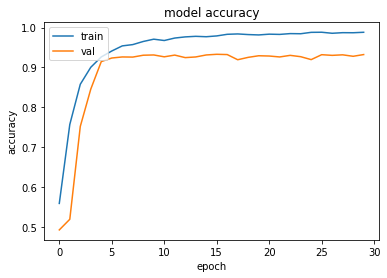

In [ ]:
plt.plot(glvHistory_3064.history['accuracy'])
plt.plot(glvHistory_3064.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

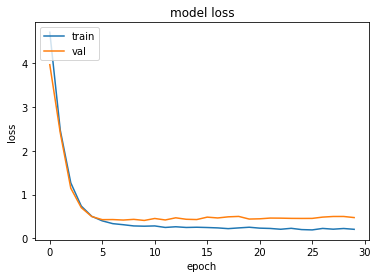

In [ ]:
plt.plot(glvHistory_3064.history['loss'])
plt.plot(glvHistory_3064.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model2.evaluate(X_test, y_test, batch_size=64)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

79/79 [==============================] - 2s 23ms/step - loss: 0.4807 - accuracy: 0.9296
Model loss: 0.4807102680206299
Model acc: 0.9296000003814697


### Epochs 30, batch size 128

In [ ]:
glvHistory_30128 = model2.fit(X_train, y_train, 
                          epochs=30, 
                          validation_split=0.2, 
                          batch_size=128,
                          validation_data=(X_test, y_test))

Epoch 1/30
94/94 [==============================] - 63s 641ms/step - loss: 4.9679 - accuracy: 0.5461 - val_loss: 3.9936 - val_accuracy: 0.4923
Epoch 2/30
94/94 [==============================] - 60s 635ms/step - loss: 3.1444 - accuracy: 0.6585 - val_loss: 3.1189 - val_accuracy: 0.4923
Epoch 3/30
94/94 [==============================] - 56s 595ms/step - loss: 1.9030 - accuracy: 0.7921 - val_loss: 2.4361 - val_accuracy: 0.4950
Epoch 4/30
94/94 [==============================] - 58s 613ms/step - loss: 1.1636 - accuracy: 0.8624 - val_loss: 1.5759 - val_accuracy: 0.5473
Epoch 5/30
94/94 [==============================] - 56s 599ms/step - loss: 0.7533 - accuracy: 0.9020 - val_loss: 1.0147 - val_accuracy: 0.7220
Epoch 6/30
94/94 [==============================] - 57s 611ms/step - loss: 0.5410 - accuracy: 0.9228 - val_loss: 0.5887 - val_accuracy: 0.8770
Epoch 7/30
94/94 [==============================] - 57s 605ms/step - loss: 0.4298 - accuracy: 0.9384 - val_loss: 0.5104 - val_accuracy: 0.8870

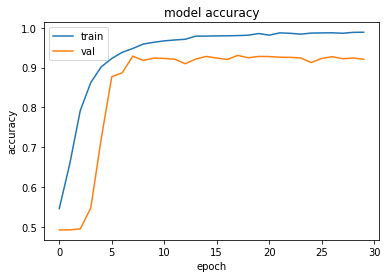

In [ ]:
plt.plot(glvHistory_30128.history['accuracy'])
plt.plot(glvHistory_30128.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

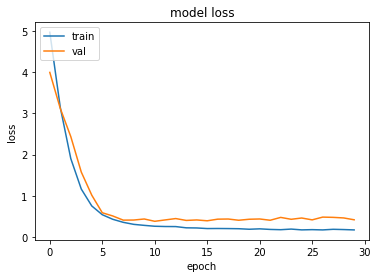

In [ ]:
plt.plot(glvHistory_30128.history['loss'])
plt.plot(glvHistory_30128.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model2.evaluate(X_test, y_test, batch_size=128)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

40/40 [==============================] - 2s 41ms/step - loss: 0.3823 - accuracy: 0.9306
Model loss: 0.3823109269142151
Model acc: 0.9305999875068665


### Fixed model (epochs 30 batch size 128)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01),
                  kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01),
                  kernel_initializer='he_normal'))
model.add(MaxPooling1D(pool_size=3))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(32, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 300)           45000000  
                                                                 
 batch_normalization (BatchN  (None, 30, 300)          1200      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 30, 300)           0         
                                                                 
 conv1d (Conv1D)             (None, 30, 128)           192128    
                                                                 
 batch_normalization_1 (Batc  (None, 30, 128)          512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
cnnModelglv = model.fit(X_train, y_train,
                        epochs=30,
                        batch_size=128,
                        validation_data=(X_test, y_test))

Epoch 1/30
118/118 [==============================] - 92s 735ms/step - loss: 4.7442 - accuracy: 0.5524 - val_loss: 3.6808 - val_accuracy: 0.5048
Epoch 2/30
118/118 [==============================] - 82s 697ms/step - loss: 2.7041 - accuracy: 0.6995 - val_loss: 2.9670 - val_accuracy: 0.5048
Epoch 3/30
118/118 [==============================] - 80s 679ms/step - loss: 1.4701 - accuracy: 0.8329 - val_loss: 1.9819 - val_accuracy: 0.5098
Epoch 4/30
118/118 [==============================] - 80s 678ms/step - loss: 0.8382 - accuracy: 0.8924 - val_loss: 0.8567 - val_accuracy: 0.7810
Epoch 5/30
118/118 [==============================] - 85s 722ms/step - loss: 0.5438 - accuracy: 0.9229 - val_loss: 0.5278 - val_accuracy: 0.8950
Epoch 6/30
118/118 [==============================] - 79s 671ms/step - loss: 0.4106 - accuracy: 0.9377 - val_loss: 0.4402 - val_accuracy: 0.9070
Epoch 7/30
118/118 [==============================] - 85s 717ms/step - loss: 0.3384 - accuracy: 0.9493 - val_loss: 0.4002 - val_ac

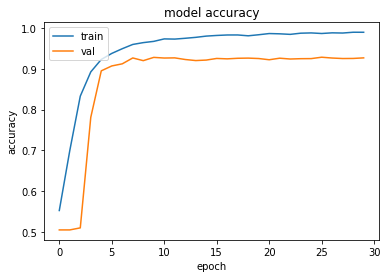

In [ ]:
plt.plot(cnnModelglv.history['accuracy'])
plt.plot(cnnModelglv.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

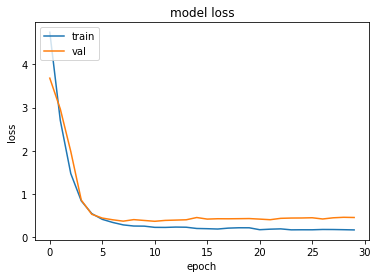

In [ ]:
plt.plot(cnnModelglv.history['loss'])
plt.plot(cnnModelglv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model.evaluate(X_test, y_test, batch_size=128)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

40/40 [==============================] - 3s 78ms/step - loss: 0.4534 - accuracy: 0.9268
Model loss: 0.4533730447292328
Model acc: 0.926800012588501


# FastText

## Embedding layer

In [ ]:
pretrainedpath = 'MyDrive/dataset/fasttext_model.bin'
fasttext_model = KeyedVectors.load_word2vec_format('drive/MyDrive/dataset/fasttext_model.bin', binary=True)
print('Model fasttext loaded.')

2022-07-24 07:53:18,758 : INFO : loading projection weights from drive/MyDrive/dataset/fasttext_model.bin
2022-07-24 07:53:24,566 : INFO : loaded (150000, 300) matrix from drive/MyDrive/dataset/fasttext_model.bin


Model fasttext loaded.


In [ ]:
embedding_layer = Embedding(input_dim=150000, output_dim=300, weights=[fasttext_model.vectors], 
                            input_length=X.shape[1])
print('Embedding layer defined.')

Embedding layer defined.


## CNN Model

In [ ]:
model3 = Sequential()
model3.add(embedding_layer)
model3.add(BatchNormalization())
model3.add(Dropout(0.4))
model3.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01),
                  kernel_initializer='he_normal'))
model3.add(BatchNormalization())
model3.add(Dropout(0.4))
model3.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01),
                  kernel_initializer='he_normal'))
model3.add(MaxPooling1D(pool_size=3))
model3.add(BatchNormalization())
model3.add(Dropout(0.4))
model3.add(Flatten())
model3.add(BatchNormalization())
model3.add(Dropout(0.4))
model3.add(Dense(64, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.4))
model3.add(Dense(32, activation = 'relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.4))
model3.add(Dense(1, activation='sigmoid'))

adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 300)           45000000  
                                                                 
 batch_normalization (BatchN  (None, 30, 300)          1200      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 30, 300)           0         
                                                                 
 conv1d (Conv1D)             (None, 30, 128)           192128    
                                                                 
 batch_normalization_1 (Batc  (None, 30, 128)          512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Hyperparameter tuning 

### Epochs 20, batch size 32

In [ ]:
ftHistory_2032 = model3.fit(X_train, y_train, 
                          epochs=20, 
                          validation_split=0.2, 
                          batch_size=32,
                          validation_data=(X_test, y_test))

Epoch 1/20
375/375 [==============================] - 206s 537ms/step - loss: 4.1265 - accuracy: 0.5373 - val_loss: 2.5370 - val_accuracy: 0.4923
Epoch 2/20
375/375 [==============================] - 197s 526ms/step - loss: 1.4387 - accuracy: 0.8493 - val_loss: 0.7963 - val_accuracy: 0.9190
Epoch 3/20
375/375 [==============================] - 196s 523ms/step - loss: 0.5297 - accuracy: 0.9388 - val_loss: 0.4963 - val_accuracy: 0.9200
Epoch 4/20
375/375 [==============================] - 196s 522ms/step - loss: 0.3095 - accuracy: 0.9608 - val_loss: 0.4212 - val_accuracy: 0.9273
Epoch 5/20
375/375 [==============================] - 197s 527ms/step - loss: 0.2489 - accuracy: 0.9707 - val_loss: 0.4357 - val_accuracy: 0.9227
Epoch 6/20
375/375 [==============================] - 197s 525ms/step - loss: 0.2592 - accuracy: 0.9708 - val_loss: 0.4483 - val_accuracy: 0.9267
Epoch 7/20
375/375 [==============================] - 195s 520ms/step - loss: 0.2389 - accuracy: 0.9739 - val_loss: 0.4437 -

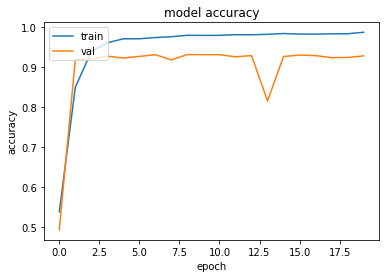

In [ ]:
plt.plot(ftHistory_2032.history['accuracy'])
plt.plot(ftHistory_2032.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

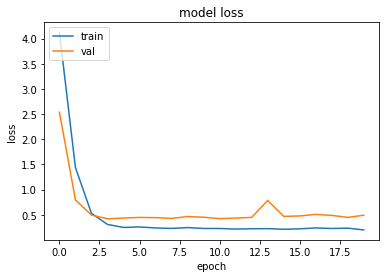

In [ ]:
plt.plot(ftHistory_2032.history['loss'])
plt.plot(ftHistory_2032.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model3.evaluate(X_test, y_test, batch_size=32)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

157/157 [==============================] - 2s 14ms/step - loss: 0.5386 - accuracy: 0.9200
Model loss: 0.5385560989379883
Model acc: 0.9200000166893005


### Epochs 20, batch size 64

In [ ]:
ftHistory_2064 = model3.fit(X_train, y_train, 
                          epochs=20, 
                          validation_split=0.2, 
                          batch_size=64,
                          validation_data=(X_test, y_test))

Epoch 1/20
188/188 [==============================] - 108s 560ms/step - loss: 4.6082 - accuracy: 0.5591 - val_loss: 3.2764 - val_accuracy: 0.5077
Epoch 2/20
188/188 [==============================] - 105s 556ms/step - loss: 2.0639 - accuracy: 0.8628 - val_loss: 2.0539 - val_accuracy: 0.5143
Epoch 3/20
188/188 [==============================] - 103s 549ms/step - loss: 0.8561 - accuracy: 0.9461 - val_loss: 0.7683 - val_accuracy: 0.8730
Epoch 4/20
188/188 [==============================] - 103s 548ms/step - loss: 0.3918 - accuracy: 0.9712 - val_loss: 0.4308 - val_accuracy: 0.9313
Epoch 5/20
188/188 [==============================] - 104s 555ms/step - loss: 0.2403 - accuracy: 0.9763 - val_loss: 0.4096 - val_accuracy: 0.9150
Epoch 6/20
188/188 [==============================] - 103s 549ms/step - loss: 0.1868 - accuracy: 0.9800 - val_loss: 0.3768 - val_accuracy: 0.9297
Epoch 7/20
188/188 [==============================] - 103s 549ms/step - loss: 0.1656 - accuracy: 0.9819 - val_loss: 0.3739 -

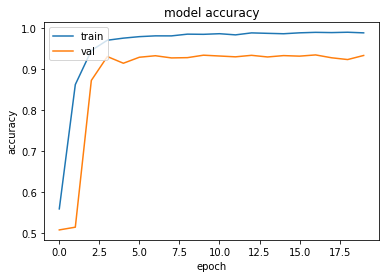

In [ ]:
plt.plot(ftHistory_2064.history['accuracy'])
plt.plot(ftHistory_2064.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

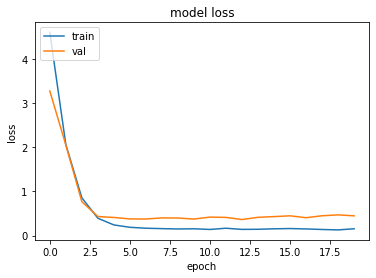

In [ ]:
plt.plot(ftHistory_2064.history['loss'])
plt.plot(ftHistory_2064.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model3.evaluate(X_test, y_test)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

157/157 [==============================] - 2s 13ms/step - loss: 0.5206 - accuracy: 0.9250
Model loss: 0.5206463932991028
Model acc: 0.925000011920929


### Epochs 20, batch size 128

In [ ]:
ftHistory_20128 = model3.fit(X_train, y_train, 
                          epochs=20, 
                          validation_split=0.2, 
                          batch_size=128,
                          validation_data=(X_test, y_test))

Epoch 1/20
94/94 [==============================] - 92s 863ms/step - loss: 4.6345 - accuracy: 0.8036 - val_loss: 4.2114 - val_accuracy: 0.5077
Epoch 2/20
94/94 [==============================] - 63s 668ms/step - loss: 2.3187 - accuracy: 0.9793 - val_loss: 3.2532 - val_accuracy: 0.5077
Epoch 3/20
94/94 [==============================] - 64s 683ms/step - loss: 1.0532 - accuracy: 0.9859 - val_loss: 2.7684 - val_accuracy: 0.5077
Epoch 4/20
94/94 [==============================] - 62s 656ms/step - loss: 0.4920 - accuracy: 0.9898 - val_loss: 1.7255 - val_accuracy: 0.5343
Epoch 5/20
94/94 [==============================] - 62s 655ms/step - loss: 0.2596 - accuracy: 0.9898 - val_loss: 0.6534 - val_accuracy: 0.8487
Epoch 6/20
94/94 [==============================] - 61s 653ms/step - loss: 0.1846 - accuracy: 0.9885 - val_loss: 0.4121 - val_accuracy: 0.9277
Epoch 7/20
94/94 [==============================] - 62s 663ms/step - loss: 0.1503 - accuracy: 0.9888 - val_loss: 0.4349 - val_accuracy: 0.9333

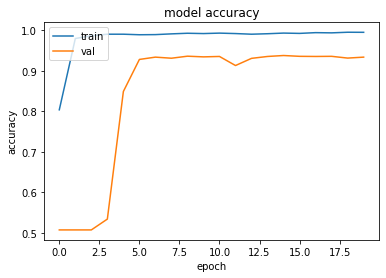

In [ ]:
plt.plot(ftHistory_20128.history['accuracy'])
plt.plot(ftHistory_20128.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

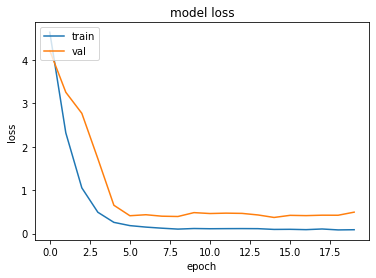

In [ ]:
plt.plot(ftHistory_20128.history['loss'])
plt.plot(ftHistory_20128.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model3.evaluate(X_test, y_test)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

157/157 [==============================] - 5s 31ms/step - loss: 0.4900 - accuracy: 0.9220
Model loss: 0.4900365173816681
Model acc: 0.921999990940094


### Epochs 30, batch size 32

In [ ]:
ftHistory_3032 = model3.fit(X_train, y_train, 
                          epochs=30, 
                          validation_split=0.2, 
                          batch_size=32,
                          validation_data=(X_test, y_test))

Epoch 1/30
375/375 [==============================] - 191s 504ms/step - loss: 4.2431 - accuracy: 0.5857 - val_loss: 2.7716 - val_accuracy: 0.4923
Epoch 2/30
375/375 [==============================] - 184s 492ms/step - loss: 1.5022 - accuracy: 0.8855 - val_loss: 0.8820 - val_accuracy: 0.9183
Epoch 3/30
375/375 [==============================] - 184s 492ms/step - loss: 0.5591 - accuracy: 0.9439 - val_loss: 0.5028 - val_accuracy: 0.9270
Epoch 4/30
375/375 [==============================] - 185s 494ms/step - loss: 0.3280 - accuracy: 0.9575 - val_loss: 0.4127 - val_accuracy: 0.9217
Epoch 5/30
375/375 [==============================] - 189s 505ms/step - loss: 0.2656 - accuracy: 0.9658 - val_loss: 0.4223 - val_accuracy: 0.9187
Epoch 6/30
375/375 [==============================] - 186s 497ms/step - loss: 0.2471 - accuracy: 0.9674 - val_loss: 0.4437 - val_accuracy: 0.9303
Epoch 7/30
375/375 [==============================] - 186s 497ms/step - loss: 0.2565 - accuracy: 0.9728 - val_loss: 0.4516 -

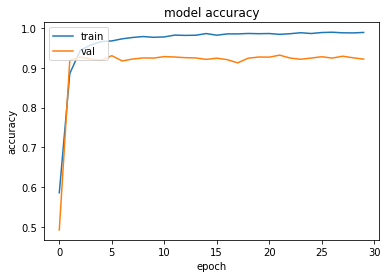

In [ ]:
plt.plot(ftHistory_3032.history['accuracy'])
plt.plot(ftHistory_3032.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

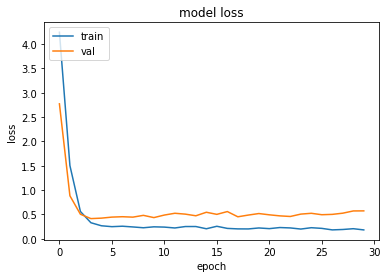

In [ ]:
plt.plot(ftHistory_3032.history['loss'])
plt.plot(ftHistory_3032.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model3.evaluate(X_test, y_test)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

157/157 [==============================] - 5s 32ms/step - loss: 0.5829 - accuracy: 0.9214
Model loss: 0.5828804969787598
Model acc: 0.9214000105857849


### Epochs 30, batch size 64

In [ ]:
ftHistory_3064 = model3.fit(X_train, y_train, 
                          epochs=30, 
                          validation_split=0.2, 
                          batch_size=64,
                          validation_data=(X_test, y_test))

Epoch 1/30
188/188 [==============================] - 110s 570ms/step - loss: 4.7237 - accuracy: 0.5347 - val_loss: 3.3578 - val_accuracy: 0.5077
Epoch 2/30
188/188 [==============================] - 105s 561ms/step - loss: 2.2669 - accuracy: 0.8117 - val_loss: 1.7656 - val_accuracy: 0.5833
Epoch 3/30
188/188 [==============================] - 104s 553ms/step - loss: 0.9843 - accuracy: 0.9384 - val_loss: 0.8335 - val_accuracy: 0.8797
Epoch 4/30
188/188 [==============================] - 104s 552ms/step - loss: 0.4617 - accuracy: 0.9655 - val_loss: 0.4195 - val_accuracy: 0.9377
Epoch 5/30
188/188 [==============================] - 105s 559ms/step - loss: 0.2681 - accuracy: 0.9751 - val_loss: 0.4318 - val_accuracy: 0.9243
Epoch 6/30
188/188 [==============================] - 104s 553ms/step - loss: 0.2008 - accuracy: 0.9793 - val_loss: 0.3617 - val_accuracy: 0.9377
Epoch 7/30
188/188 [==============================] - 104s 553ms/step - loss: 0.1904 - accuracy: 0.9801 - val_loss: 0.3990 -

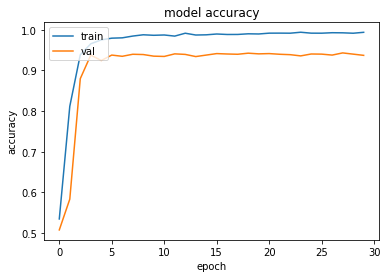

In [ ]:
plt.plot(ftHistory_3064.history['accuracy'])
plt.plot(ftHistory_3064.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

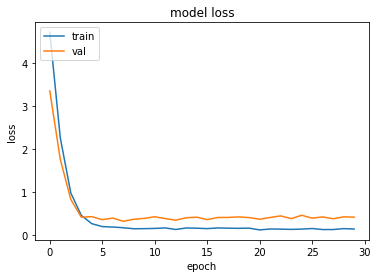

In [ ]:
plt.plot(ftHistory_3064.history['loss'])
plt.plot(ftHistory_3064.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model3.evaluate(X_test, y_test)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

157/157 [==============================] - 2s 13ms/step - loss: 0.4896 - accuracy: 0.9262
Model loss: 0.4895704686641693
Model acc: 0.9261999726295471


### Epochs 30, batch size 128

In [ ]:
ftHistory_30128 = model3.fit(X_train, y_train, 
                          epochs=30, 
                          validation_split=0.2, 
                          batch_size=128,
                          validation_data=(X_test, y_test))

Epoch 1/30
94/94 [==============================] - 68s 702ms/step - loss: 5.0934 - accuracy: 0.5268 - val_loss: 3.9672 - val_accuracy: 0.4923
Epoch 2/30
94/94 [==============================] - 62s 662ms/step - loss: 3.0788 - accuracy: 0.7080 - val_loss: 2.5191 - val_accuracy: 0.4923
Epoch 3/30
94/94 [==============================] - 62s 661ms/step - loss: 1.6168 - accuracy: 0.9177 - val_loss: 1.5950 - val_accuracy: 0.5597
Epoch 4/30
94/94 [==============================] - 62s 663ms/step - loss: 0.8493 - accuracy: 0.9631 - val_loss: 1.0905 - val_accuracy: 0.6317
Epoch 5/30
94/94 [==============================] - 62s 661ms/step - loss: 0.4620 - accuracy: 0.9760 - val_loss: 0.6918 - val_accuracy: 0.8043
Epoch 6/30
94/94 [==============================] - 62s 663ms/step - loss: 0.2863 - accuracy: 0.9797 - val_loss: 0.6446 - val_accuracy: 0.8203
Epoch 7/30
94/94 [==============================] - 62s 663ms/step - loss: 0.1888 - accuracy: 0.9836 - val_loss: 0.3462 - val_accuracy: 0.9267

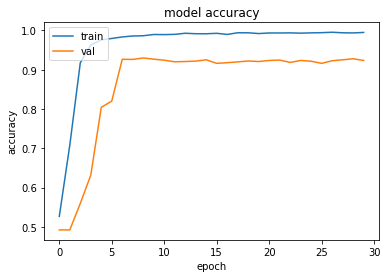

In [ ]:
plt.plot(ftHistory_30128.history['accuracy'])
plt.plot(ftHistory_30128.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

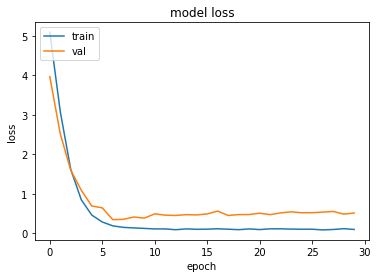

In [ ]:
plt.plot(ftHistory_30128.history['loss'])
plt.plot(ftHistory_30128.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model3.evaluate(X_test, y_test)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

157/157 [==============================] - 2s 14ms/step - loss: 0.4679 - accuracy: 0.9294
Model loss: 0.4679190516471863
Model acc: 0.9294000267982483
